<a href="https://colab.research.google.com/github/IfatKhan111/Cricket-Shot-Classification-using-VGG-CNN-LSTM/blob/main/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import math
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Function to extract VGG16 features from frames
def extract_features(frames):
    model = VGG16(weights='imagenet', include_top=False)
    features_list = []
    for frame in frames:
        resized_frame = cv2.resize(frame, (224, 224))
        expanded_frame = np.expand_dims(resized_frame, axis=0)
        features = model.predict(expanded_frame, verbose=0)
        features_list.append(features.flatten())
    return features_list

In [ ]:
# Define the data path
data_path = '/content/drive/MyDrive/Dataset'

In [ ]:
# List all folders in the data path
contents = os.listdir(data_path)
folder_names = [item for item in contents if os.path.isdir(os.path.join(data_path, item))]

In [ ]:
# Process each folder
all_features = []
all_labels = []
num_videos_per_folder = 3  # Specify the number of videos to process from each folder
for i, folder in enumerate(folder_names):
    print(f"Processing folder: {folder}")
    folder_path = os.path.join(data_path, folder)
    filenames = [filename for filename in os.listdir(folder_path) if filename.endswith('.mp4')][:num_videos_per_folder]
    for filename in filenames:
        filepath = os.path.join(folder_path, filename)
        cap = cv2.VideoCapture(filepath)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
        features = extract_features(frames)
        labels = [i] * len(features)
        all_features.extend(features)
        all_labels.extend(labels)
        cap.release()


Processing folder: Cover Drive
Processing folder: Pull
Processing folder: Sweep


In [ ]:
# Convert features and labels to NumPy arrays
X = np.array(all_features)
y = np.array(all_labels)

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print the shape of X_train for debugging
print(f"Shape of X_train: {X_train.shape}")

Shape of X_train: (160, 25088)


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

In [ ]:
model = tf.keras.Sequential([

    tf.keras.layers.Reshape((1, X_train.shape[1]), input_shape=(X_train.shape[1],)),

    tf.keras.layers.LSTM(256, return_sequences=True),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.LSTM(128, return_sequences=True),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.LSTM(64, return_sequences=True),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.LSTM(32),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(len(folder_names), activation='softmax')

])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
!apt-get -qq install -y graphviz && pip install pydot
import pydot

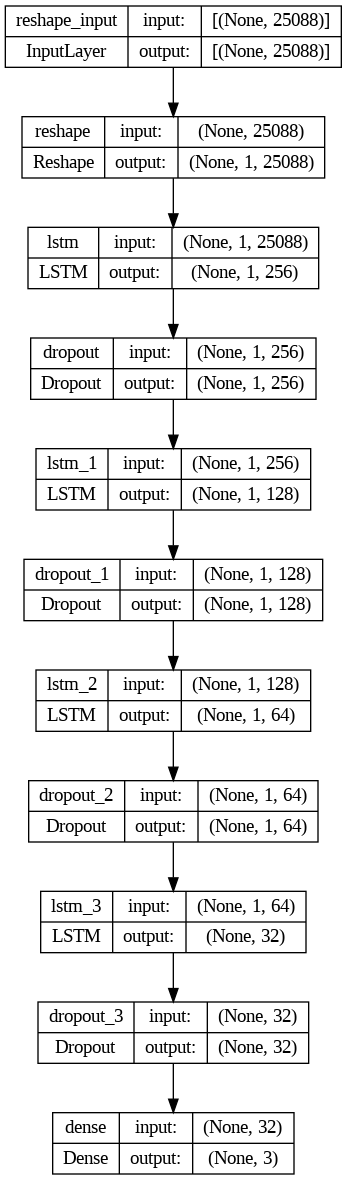

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
!pip install visualkeras
!pip install pydot

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [ ]:
# Train the model
history = model.fit(X_train, y_train_encoded, epochs=13, batch_size=32, validation_data=(X_val, y_val_encoded), callbacks=[early_stopping, reduce_lr])

Epoch 1/13
5/5 [==============================] - 12s 1s/step - loss: 1.0969 - accuracy: 0.3812 - val_loss: 1.0905 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 2/13
5/5 [==============================] - 5s 1s/step - loss: 1.0899 - accuracy: 0.5750 - val_loss: 1.0843 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 3/13
5/5 [==============================] - 5s 971ms/step - loss: 1.0811 - accuracy: 0.6000 - val_loss: 1.0730 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 4/13
5/5 [==============================] - 5s 999ms/step - loss: 1.0717 - accuracy: 0.6375 - val_loss: 1.0568 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 5/13
5/5 [==============================] - 5s 1s/step - loss: 1.0521 - accuracy: 0.6125 - val_loss: 1.0240 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 6/13
5/5 [==============================] - 5s 1s/step - loss: 1.0166 - accuracy: 0.6625 - val_loss: 0.9754 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/13
5/5 [==============================] - 5s 988ms/step - loss: 0.9709 - accuracy: 0.

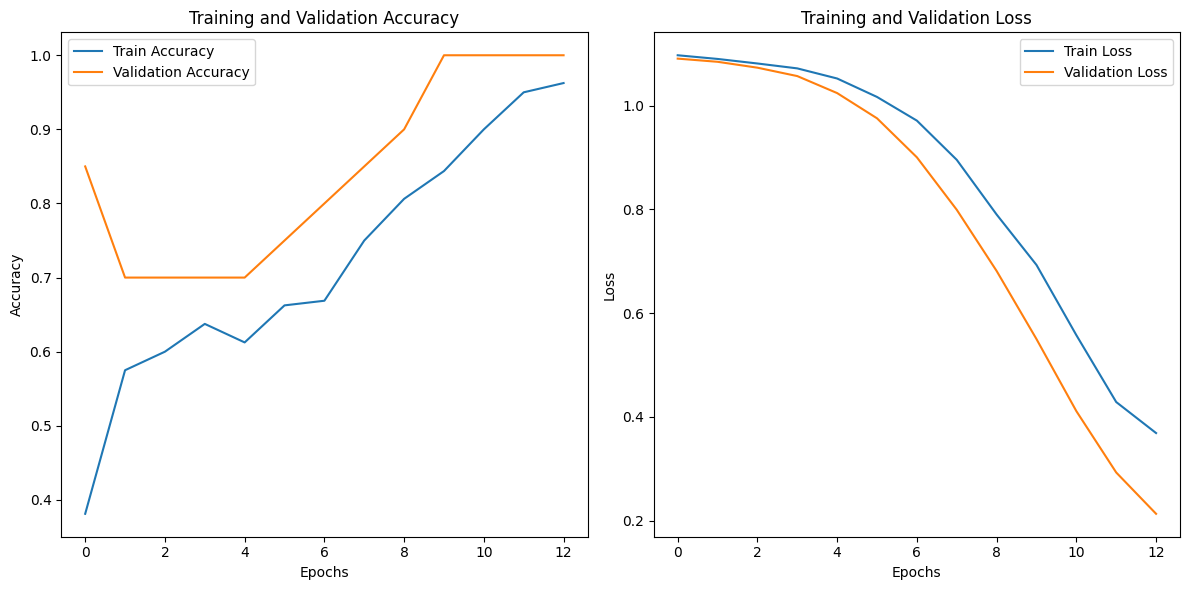

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))

# Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 1s/step


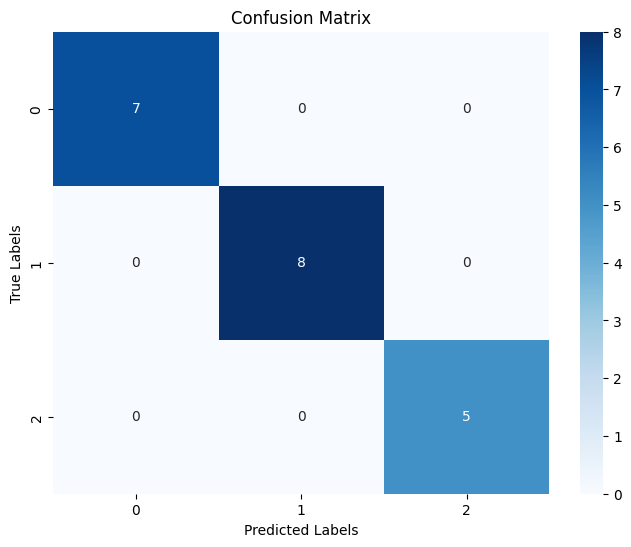


Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         7
     Class 1       1.00      1.00      1.00         8
     Class 2       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy: 1.00


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predict using the trained model
y_pred = model.predict(X_test)  # X_test contains test images
y_pred = np.argmax(y_pred, axis=1)  # Convert softmax outputs to class labels

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report
class_report = classification_report(y_test_encoded, y_pred, target_names=[f'Class {i}' for i in np.unique(y_test_encoded)])
print("\nClassification Report:\n", class_report)

# Optional: Calculate and display accuracy, precision, recall, and F1 score manually
accuracy = np.mean(y_test_encoded == y_pred)
print(f"Accuracy: {accuracy:.2f}")